In [1]:
import juliacall
import numpy as np
import fit_modeler
import evolve_binary
import pandas as pd
import time, os
import surrogate
from astropy import constants as const
import matplotlib.pyplot as plt

from mcfacts.vis import plotting
from mcfacts.vis import styles

np.set_printoptions(legacy='1.13')

### Should work for everyone ###
# Current directory
#HERE=$(shell pwd)
#/Users/sray/Documents/1Saavik_Barry/test_mcfacts
#os.getcwd()
HERE = '/Users/sray/Documents/1Saavik_Barry/test_mcfacts'

#### Scripts ####
# Change final number of zeros depending on how many galaxies are initialized (example: 1 galaxy - 'runs/gal0'; 10 galaxies - 'runs/gal00'; 100 galaxies -'runs/gal000')
MCFACTS_RUNS_GAL = HERE + '/runs/gal00'
MCFACTS_RUNS = HERE + '/runs'

# Code that will match the number of objects and galaxies being run without the user having to change it manually
dir_path = (MCFACTS_RUNS_GAL)
objects = int((len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]) - 2)/3)
galaxies = len(next(os.walk(MCFACTS_RUNS))[1])

# Change value of n - zfill(n) - to match the order of magnitude of number of galaxies being run
gal = [str(i).zfill(2) for i in range(galaxies)]
obj = [str(i) for i in range(objects)]
runs = [[] for _ in range(len(gal))]

for i in range(len(gal)):
    for j in range(len(obj)):
        temp = '/Users/sray/Documents/1Saavik_Barry/test_mcfacts/runs/gal' + gal[i] + '/output_bh_binary_' + obj[j] + '.dat'
        runs[i].append(temp)

with open("Output.txt", "w") as text_file:
    text_file.write(str(gal))
    
# Setting up surrogate model
surrogate = fit_modeler.GPRFitters.read_from_file(f"surrogate.joblib")

# Creating a hard coded binary seperation to speed up the surrogate model 
# ========= NEEDS CHANGES: change hard set binary value to change depending on the mass ratio ============
def new_bin_sep(freq, i):
    active_bin = pd.read_csv(i, delimiter=' ', header = 0)
    mass_1 = active_bin['mass_1']
    mass_2 = active_bin['mass_2']
    #print(mass_1)
    G = const.G.value
    M_dot = 2e30
    grav_freq = freq
    
    #print('mass_1: ', active_bin['mass_1'])
    #print('grav_freq: ', active_bin['gw_freq'])
    
    a_bin = ((G * (mass_1 + mass_2) * M_dot * np.pi**2) / grav_freq**2) ** (1/3)
    #a_bin = ((G * (mass_1 + mass_2) * M_dot) / (16 * grav_freq**2 * np.pi**2))**1/3
    a_bin_rg = a_bin / 1.5e11
    return a_bin_rg

total_mass_final = []
total_spin_final = []
total_velocity_final = []
total_radius_final = []
total_gen_final = []

num_of_obj_mergers = []
num_of_gal_mergers = []

sur_time_start = time.time()

# Starting loops to determine binary merger events 
# Beginning with a new galaxy and iterating through each of the timesteps within the galaxy
for i in range(len(gal)):
    merger_counter_gal = []
    print('===================================   NEW GALAXY   =================================')
    for j in range(len(obj)):
        if j == 0:
            continue
        merger_counter_obj = []
        total_start_mass1 = []
        total_start_mass2 = []
        total_start_spin1 = []
        total_start_spin2 = []
        
        #The following logic systems use the current binary as the base for checks
        active_bin = pd.read_csv(runs[i][j], delimiter=' ', header = 0)
        print('----------------     NEW TIMESTEP     ----------------')
        mass_final = []
        spin_final = []
        velocity_final = []
        radius_final = []
        gen_final = []
        
        starting_mass1 = []
        starting_mass2 = []
        starting_spin1 = []
        starting_spin2 = []
        
        # This checks if the current timestep is empty
        if active_bin.empty:
            print('Galaxy ', gal[i], ' and run ', obj[j])
            print('file is empty. Checking for previous binaries and moving onto next system')
            act_bin_prev = pd.read_csv(runs[i][j-1], delimiter=' ', header = 0)
            
            bh_prev = act_bin_prev['id_num']
            bh = active_bin['id_num']
            
            #This loop checks if there are any previously generated binaries
            # If there are any previously merged binaries, then this must mean those binaries have merged
            #  since the current timestep is empty.
            if bh_prev.empty:
                print('no previously merged binaries')
            else:
                for values in bh_prev:
                    print('binary ', values, ' has merged...beginning surrogate model')
                    #merger_counter_obj.append(obj[j])
                    for k in range(len(act_bin_prev['mass_1'])):
                        mass_1 = act_bin_prev['mass_1'][k]
                        mass_2 = act_bin_prev['mass_2'][k]
                        spin_1_mag = act_bin_prev['spin_1'][k]
                        spin_2_mag = act_bin_prev['spin_2'][k]
                        spin_angle_1 = act_bin_prev['spin_angle_1'][k]
                        spin_angle_2 = act_bin_prev['spin_angle_2'][k]
                        radius = act_bin_prev['bin_orb_a'][k]
                        gen_1 = act_bin_prev['gen_1'][k]
                        gen_2 = act_bin_prev['gen_2'][k]
                        phi_12 = spin_angle_2 - spin_angle_1
                        # This should be in units of mass_1 + mass_2
                        bin_sep = 1000
                        bin_inc = [0, 0, 1]
                        bin_phase = 0
                        # These next three are used to correct the remnant velocity;
                        # If they are None, no correction is applied.
                        bin_orb_a = None
                        mass_SMBH = None
                        spin_SMBH = None

                        surrogate = fit_modeler.GPRFitters.read_from_file(f"surrogate.joblib")

                        start = time.time()
                        M_f, spin_f, v_f = evolve_binary.evolve_binary(
                            mass_1,
                            mass_2,
                            spin_1_mag,
                            spin_2_mag,
                            spin_angle_1,
                            spin_angle_2,
                            phi_12,
                            bin_sep,
                            bin_inc,
                            bin_phase,
                            bin_orb_a,
                            mass_SMBH,
                            spin_SMBH,
                            surrogate,
                            verbose=True,
                        )
                        end = time.time()
                        
                        run_time = end - start

                        mass_final.append(M_f)
                        spin_final.append(spin_f)
                        velocity_final.append(v_f)
                        radius_final.append(radius)
                        '''# Checking generation values to ensure that correct generation of remnant is allocated
                        if int(gen_1) == 1 or int(gen_2) == 1:
                            gen_final.append(gen_1 + gen_2)
                        else:
                            if int(gen_1) > int(gen_2):
                                gen_final.append(gen_1 + 1)
                            elif int(gen_2) > int(gen_1):
                                gen_final.append(gen_2 + 1)
                            else:
                                gen_final.append(gen_1 + 1)'''
                        
                    print("M_f = ", M_f)
                    print("spin_f = ", spin_f)
                    print("v_f = ", v_f)
                    print("Merger took ", run_time, " seconds")
        
        else:
            print('Galaxy ', gal[i], ' and run ', obj[j])
            print('binary found at galaxy ', gal[i], ' and binary ', obj[j])
            act_bin_prev = pd.read_csv(runs[i][j-1], delimiter=' ', header = 0)
            
            mass_1 = act_bin_prev['mass_1']
            mass_2 = act_bin_prev['mass_2']
            spin_1 = act_bin_prev['spin_1']
            spin_2 = act_bin_prev['spin_2']
            spin_angle_1 = act_bin_prev['spin_angle_1']
            spin_angle_2 = act_bin_prev['spin_angle_2']
            
            bh_prev = act_bin_prev['id_num'].values
            bh = active_bin['id_num'].values
            
            #This loop check to see if any binaries have formed
            for value in bh:
                if act_bin_prev.empty:
                    print('binary ', value, ' has formed')
                elif value not in bh_prev:
                    print('binary ', value, ' has formed')
                else:
                    print('binary ', value, ' has not yet mergered')
            
            for value in bh_prev:
                if value not in bh:
                    print('binary ', value, ' has merged...beginning surrogate model')
                    #merger_counter_obj.append(obj[j])
                    for k in range(len(act_bin_prev['mass_1'])):
                        mass_1 = act_bin_prev['mass_1'][k]
                        mass_2 = act_bin_prev['mass_2'][k]
                        spin_1_mag = act_bin_prev['spin_1'][k]
                        spin_2_mag = act_bin_prev['spin_2'][k]
                        spin_angle_1 = act_bin_prev['spin_angle_1'][k]
                        spin_angle_2 = act_bin_prev['spin_angle_2'][k]
                        radius = act_bin_prev['bin_orb_a'][k]
                        gen_1 = act_bin_prev['gen_1'][k]
                        gen_2 = act_bin_prev['gen_2'][k]
                        phi_12 = spin_angle_2 - spin_angle_1
                        # This should be in units of mass_1 + mass_2
                        bin_sep = 1000
                        bin_inc = [0, 0, 1]
                        bin_phase = 0
                        # These next three are used to correct the remnant velocity;
                        # If they are None, no correction is applied.
                        bin_orb_a = None
                        mass_SMBH = None
                        spin_SMBH = None

                        surrogate = fit_modeler.GPRFitters.read_from_file(f"surrogate.joblib")

                        start = time.time()
                        M_f, spin_f, v_f = evolve_binary.evolve_binary(
                            mass_1,
                            mass_2,
                            spin_1_mag,
                            spin_2_mag,
                            spin_angle_1,
                            spin_angle_2,
                            phi_12,
                            bin_sep,
                            bin_inc,
                            bin_phase,
                            bin_orb_a,
                            mass_SMBH,
                            spin_SMBH,
                            surrogate,
                            verbose=False,
                        )
                        end = time.time()
                        
                        run_time = end - start

                        # These values are the surrogate outputs for each binary system that goes through a merger event
                        mass_final.append(M_f)
                        spin_final.append(spin_f)
                        velocity_final.append(v_f)
                        radius_final.append(radius)
                        
                        '''# Checking generation values to ensure that correct generation of remnant is allocated
                        if int(gen_1) == 1 or int(gen_2) == 1:
                            gen_final.append(gen_1 + gen_2)
                        else:
                            if int(gen_1) > int(gen_2):
                                gen_final.append(gen_1 + 1)
                            elif int(gen_2) > int(gen_1):
                                gen_final.append(gen_2 + 1)
                            else:
                                gen_final.append(gen_1 + 1)'''
                        
                        # ============= Need to incorporate starting mass to determine the initial mass compared to final mass after merger =============
                        starting_mass1.append(mass_1)
                        starting_mass2.append(mass_2)
                        starting_spin1.append(spin_1)
                        starting_spin2.append(spin_2)
                        
                    print("M_f = ", M_f)
                    print("spin_f = ", spin_f)
                    print("v_f = ", v_f)
                    print("Merger took ", run_time, " seconds")
        #merger_counter_gal.append(merger_counter_obj)
                    
        #merger_counter_gal.append(merger_counter_obj)
        #print('galaxy ', gal[i], ' had mergers at timesteps ', merger_counter_gal)
        
        # Sorting all the merger event properties into a collective list that contains all merger event properties 
        total_mass_final.append(mass_final)
        total_spin_final.append(spin_final)
        total_velocity_final.append(velocity_final)
        total_radius_final.append(radius_final)
        total_gen_final.append(gen_final)
        
        total_start_mass1.append(starting_mass1)
        total_start_mass2.append(starting_mass2)
        total_start_spin1.append(starting_spin1)
        total_start_spin2.append(starting_spin2)

# print(total_mass_final)
# print(total_spin_final)
# print(total_velocity_final)
# print(total_radius_final)
# print('\n')
# print(total_start_mass1)
# print(total_start_mass2)
# print(total_start_spin1)
# print(total_start_spin2)

sur_time_end = time.time()
final_time = sur_time_end - sur_time_start
print('//////////////////////////////////////////                FINAL RUN TIME : ', int(final_time/60), 'min -', int(final_time % 60), 'sec                 //////////////////////////////////////////')

# Since there are many timesteps that do not have merger events, there is an empty list that is pulled for the merger
# The reduced properties removes the empty lists and creates a final list with no empty sections of data
reduced_mass_final = []
reduced_spin_final = []
reduced_velocity_final = []
reduced_radius_final = []
reduced_gen_final = []

for i in range(len(total_mass_final)):
    if total_mass_final[i] != []:
        reduced_mass_final.append(total_mass_final[i])
for i in range(len(total_spin_final)):
    if total_spin_final[i] != []:
        reduced_spin_final.append(total_spin_final[i])
for i in range(len(total_velocity_final)):
    if total_velocity_final[i] != []:
        reduced_velocity_final.append(total_velocity_final[i])
for i in range(len(total_radius_final)):
    if total_radius_final[i] != []:
        reduced_radius_final.append(total_radius_final[i])
for i in range(len(total_gen_final)):
    if total_gen_final[i] != []:
        reduced_gen_final.append(total_gen_final[i])
        
# print(reduced_mass_final[2])
# print(reduced_spin_final[2])
# print(reduced_velocity_final[2])
# print(reduced_radius_final[2])
# print(reduced_radius_final[2])

# Now that we have reduced properties, that are arranged in multidimensional arrays, for each of the binaries, we need to put them into a single large binary 
# that allows us to be able to plot the values and get a visualization on how the data appears
plot_mass = []
for i in range(len(reduced_mass_final)):
    for j in range(len(reduced_mass_final[i])):
        plot_mass.append(reduced_mass_final[i][j])
# print(plot_mass)

plot_spin = []
for i in range(len(reduced_spin_final)):
    for j in range(len(reduced_spin_final[i])):
        plot_spin.append(reduced_spin_final[i][j])
# print(plot_spin)

plot_velocity = []
for i in range(len(reduced_velocity_final)):
    for j in range(len(reduced_velocity_final[i])):
        plot_velocity.append(reduced_velocity_final[i][j])
# print(plot_velocity)

plot_radius = []
for i in range(len(reduced_radius_final)):
    for j in range(len(reduced_radius_final[i])):
        plot_radius.append(reduced_radius_final[i][j])
# print(plot_radius)

plot_gen = []
for i in range(len(reduced_gen_final)):
    for j in range(len(reduced_gen_final[i])):
        plot_gen.append(reduced_gen_final[i][j])
# print(plot_gen)



# Converting spin_1 magnitude values into cartesian values
chi_mag = [[] for _ in range(len(plot_spin))] 

for i in range(len(chi_mag)):
    for j in range(len(plot_spin[i])):
        chi_mag[i] = np.sqrt(plot_spin[i][0]**2 + plot_spin[i][1]**2 + plot_spin[i][2]**2)
# print(chi_mag)

# Converting spin_1 magnitude values into cartesian values
vel_mag = [[] for _ in range(len(plot_velocity))] 

for i in range(len(vel_mag)):
    vel_mag[i] = np.linalg.norm(plot_velocity[i]) * 100
# print(vel_mag)


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
===================================   NEW GALAXY   =================================
----------------     NEW TIMESTEP     ----------------
Galaxy  00  and run  1
file is empty. Checking for previous binaries and moving onto next system
no previously merged binaries
----------------     NEW TIMESTEP     ----------------
Galaxy  00  and run  2
file is empty. Checking for previous binaries and moving onto next system
no previously merged binaries
----------------     NEW TIMESTEP     ----------------
Galaxy  00  and run  3
file is empty. Checking for previous binaries and moving onto next system
no previously merged binaries
----------------     NEW TIMESTEP     ----------------
Galaxy  00  and run  4
file is empty. Checking for previous binaries and moving onto next system
no previously merged binaries
----------------     NEW TIMESTEP     ----------------
Galaxy  00  and ru

In [6]:
num_mergers = range(len(plot_mass))

hist_color = [styles.color_gen1, styles.color_gen2, styles.color_genX]
hist_label = ['1g-1g', '2g-1g or 2g-2g', r'$\geq$3g-Ng']

figsize = 'apj_col'


In [27]:
gen1_mask = plot_mass[0]
print(gen1_mask)

33.2397398947


Text(0.5, 1.0, 'Merger Velocities per Merger Mass')

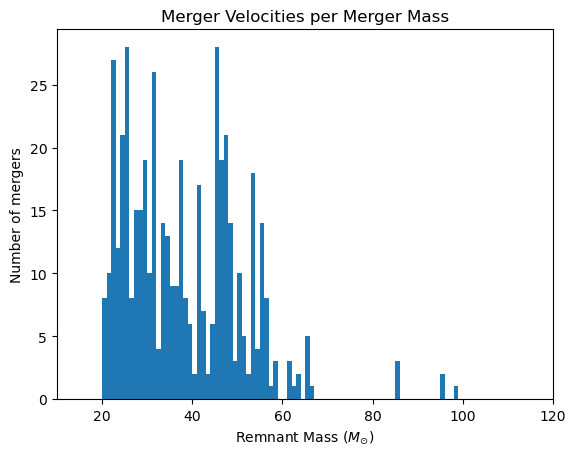

In [17]:
#fig = plt.figure(figsize=(plotting.set_size(figsize)))

plt.hist(plot_mass, num_mergers)
plt.xlabel('Remnant ' r'Mass ($M_{\odot}$)')
plt.ylabel('Number of mergers')
plt.xlim([10, 120])
plt.title('Number of mergers per remnant mass')


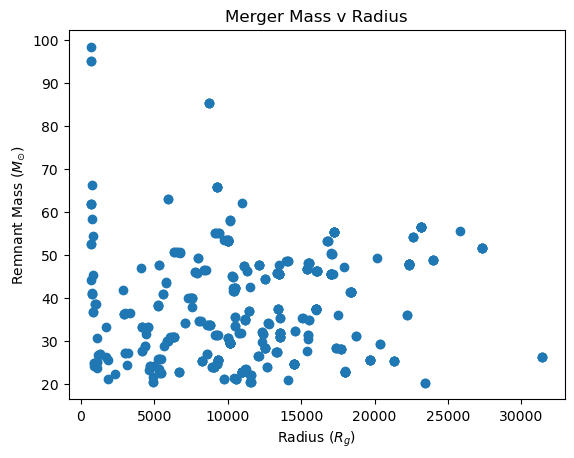

In [29]:
plt.scatter(plot_radius, plot_mass)
plt.xlabel('Radius ' r'($R_g$)')
plt.ylabel('Remnant ' r'Mass ($M_{\odot}$)')
plt.title('Merger Mass v Radius')
plt.show()

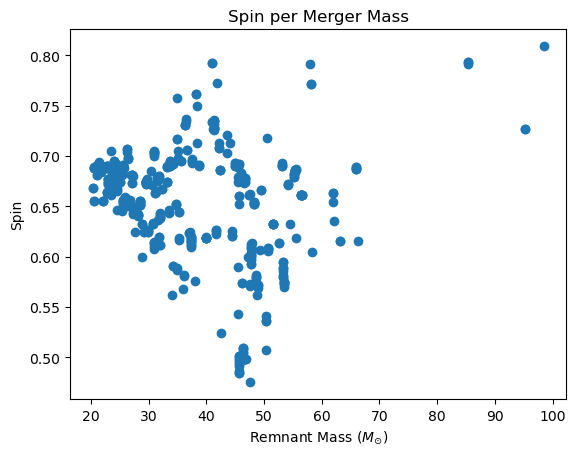

In [30]:
plt.scatter(plot_mass, chi_mag)
plt.xlabel('Remnant ' r'Mass ($M_{\odot}$)')
plt.ylabel('Spin')
plt.title('Spin per Merger Mass')
plt.show()
